In [1]:
import os
import torch
import librosa
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, root, sr=16000):
        self.sr = sr
        self.files = []
        self.labels = []

        for label, folder in enumerate(["real", "fake"]):
            folder_path = os.path.join(root, folder)
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    self.files.append(os.path.join(folder_path, file))
                    self.labels.append(label)  # real=0, fake=1

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        y, _ = librosa.load(path, sr=self.sr)
        return y, self.labels[idx]


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)  # 應該顯示 cuda

cpu


In [3]:
# wavlm_feature_extractor.py
import torch
from transformers import Wav2Vec2FeatureExtractor, WavLMModel


class WavLMEmbedding:
    def __init__(self, device =  'cuda'):
        self.device = device
        self.processor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
        self.model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus")
        self.model.to(self.device)
        self.model.eval()
    
    def extract(self, waveform):
        if not isinstance(waveform, torch.Tensor):
            waveform = torch.tensor(waveform, dtype=torch.float32)
            
        inputs = self.processor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )
        
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            out = self.model(**inputs).last_hidden_state  # [B, T, 768]

        embeddings = out.mean(dim=1)  # [B, 768]
        return embeddings


/Users/chenyitong/Desktop/研究所/資料科學/project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# model.py
import torch.nn as nn

class VoiceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
# 訓練模型
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 使用下載的數據集路徑
dataset_path = "dataset/for-rerecorded/training"
print(f"Using dataset from: {dataset_path}")

dataset = AudioDataset(dataset_path)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

feature_extractor = WavLMEmbedding(device=DEVICE)
classifier = VoiceClassifier().to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    classifier.train()
    total_loss = 0

    for waveforms, labels in tqdm(loader):
        embeddings = []

        # 抽取 WavLM embeddings (每條音檔 separately)
        for wav in waveforms:
            e = feature_extractor.extract(wav).squeeze(0)
            embeddings.append(e)

        embeddings = torch.stack(embeddings).to(DEVICE)
        labels = labels.to(DEVICE)

        logits = classifier(embeddings)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {total_loss/len(loader):.4f}")

torch.save(classifier.state_dict(), "classifier.pt")
print("模型已保存！")

Using dataset from: dataset/for-rerecorded/training


  0%|          | 0/10208 [00:00<?, ?it/s]/Users/chenyitong/Desktop/研究所/資料科學/project/venv/lib/python3.11/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 10208/10208 [12:13<00:00, 13.92it/s]


Epoch 1 Loss: 0.2821


100%|██████████| 10208/10208 [12:33<00:00, 13.55it/s]


Epoch 2 Loss: 0.1292


 91%|█████████ | 9308/10208 [11:59<01:09, 12.94it/s]



KeyboardInterrupt: 

In [7]:
# 模型推理
import torch
import librosa

classifier = VoiceClassifier().to(device)
classifier.load_state_dict(torch.load("classifier.pt", map_location=device))
classifier.eval()

feature_extractor = WavLMEmbedding(device='cuda' if torch.cuda.is_available() else 'cpu')

def predict(wav_path):
    wav, _ = librosa.load(wav_path, sr=16000)
    emb = feature_extractor.extract(wav).squeeze(0).unsqueeze(0)
    with torch.no_grad():
        logits = classifier(emb)
        pred = torch.argmax(logits, dim=1).item()
    return "real" if pred == 0 else "fake"

# 測試：使用下載的數據集中的真實文件
test_file = "dataset/for-rerecorded/training/real/recording10037.wav_norm_mono.wav"
print(f"Testing on: {test_file}")
print(f"Prediction: {predict(test_file)}")

Testing on: dataset/for-rerecorded/training/real/recording10037.wav_norm_mono.wav
Prediction: real


In [8]:
# 模型評估
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import os
import torch
import librosa

def evaluate(dataset_path):
    y_true = []
    y_pred = []
    embeddings_cache = []  # 可選：存 embedding 做 ROC

    for label_name, label_id in [("real", 0), ("fake", 1)]:
        folder = os.path.join(dataset_path, label_name)
        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue
            
        for file in os.listdir(folder):
            if not file.endswith(".wav"):
                continue
            wav_path = os.path.join(folder, file)
            try:
                wav, _ = librosa.load(wav_path, sr=16000)
                emb = feature_extractor.extract(wav).squeeze(0).unsqueeze(0)

                with torch.no_grad():
                    logits = classifier(emb)
                    pred = torch.argmax(logits, dim=1).item()
                    prob = torch.softmax(logits, dim=1)[0,1].item()  # fake 的機率

                y_true.append(label_id)
                y_pred.append(pred)
                embeddings_cache.append(prob)
            except Exception as e:
                print(f"Error processing {wav_path}: {e}")
                continue

    if len(y_true) == 0:
        print("No files were processed!")
        return
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    probs = np.array(embeddings_cache)

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    fpr, tpr, thresholds = roc_curve(y_true, probs)

    print(f"Dataset: {dataset_path}")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("AUC:", auc)
    print("Precision:", precision)
    print("Recall:", recall)

    # 畫 ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {os.path.basename(dataset_path)}")
    plt.legend()
    plt.show()

/Users/chenyitong/Desktop/研究所/資料科學/project/venv/lib/python3.11/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Dataset: dataset/for-rerecorded/validation
Accuracy: 0.9723707664884136
Confusion Matrix:
 [[1083   18]
 [  44 1099]]
AUC: 0.9971997142500694
Precision: 0.9838854073410922
Recall: 0.9615048118985127


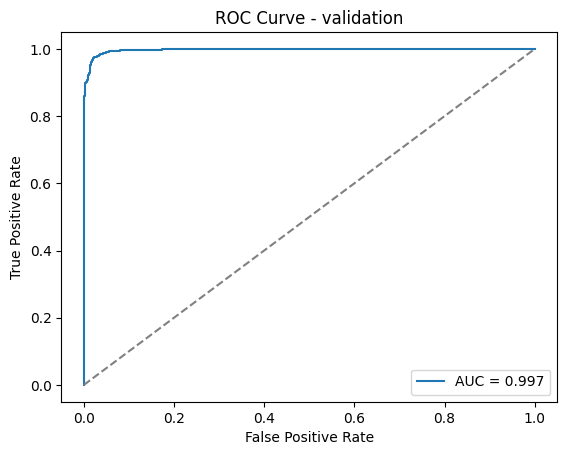

In [9]:
# 評估驗證集
val_path = "dataset/for-rerecorded/validation"
evaluate(val_path)